<a href="https://colab.research.google.com/github/juhaina1997/face_recognition/blob/main/face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os, cv2
import matplotlib.pyplot as plt
import seaborn as sns,itertools
from tensorflow.keras.applications import vgg16, ResNet50, DenseNet169
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import layers, models, Model, optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D,Dropout,Flatten

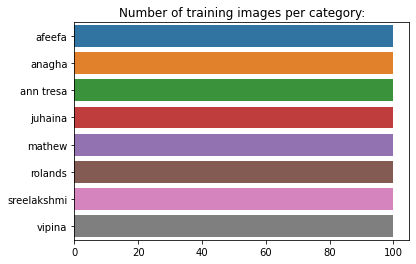

In [ ]:
train_data_dir ="dataset/train"
val_data_dir = "dataset/validation"
test_data_dir = "dataset/test"
category_names = sorted(os.listdir('dataset/train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'dataset/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")
plt.savefig('pathimg.pdf',dpi=600,bbox_inches='tight')
plt.savefig('pathimg.svg',dpi=600,bbox_inches='tight')

In [ ]:
img_height, img_width = 224,224
# only rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)
val_datagen =  ImageDataGenerator(
    rescale=1./255
)
# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
                         train_data_dir,
                         target_size = (img_height, img_width),
                         batch_size = 32,
                         class_mode = "categorical")
print('Total number of images for "validation":')
val_generator = val_datagen.flow_from_directory(
                         val_data_dir,
                         target_size = (img_height, img_width),
                         batch_size = 32,
                         class_mode = "categorical",
                         shuffle=False)
print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
                         test_data_dir,
                         target_size = (img_height, img_width),
                         batch_size = 32,
                         class_mode = "categorical",
                         shuffle=False)


Total number of images for "training":
Found 800 images belonging to 8 classes.
Total number of images for "validation":
Found 200 images belonging to 8 classes.
Total number of images for "testing":
Found 160 images belonging to 8 classes.


In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        brightness_range = (0.9,1.1),
        fill_mode='nearest'
        )
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = 32,
#save_to_dir='augm_images',
save_prefix='aug',
save_format='jpg',
class_mode = "categorical")

Found 800 images belonging to 8 classes.


# RESNET

In [ ]:
img_width, img_height=224,224
resnet_base = ResNet50(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)


In [ ]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in resnet_base.layers:
    layer.trainable=False
for layer in resnet_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001F620B50E80> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001F620BE53D0> False
<keras.layers.convolutional.Conv2D object at 0x000001F620BE5790> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F620C56640> False
<keras.layers.core.activation.Activation object at 0x000001F620012B80> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001F6202AFD30> False
<keras.layers.pooling.MaxPooling2D object at 0x000001F620C56970> False
<keras.layers.convolutional.Conv2D object at 0x000001F620B50730> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F620347B20> False
<keras.layers.core.activation.Activation object at 0x000001F620AC4AC0> False
<keras.layers.convolutional.Conv2D object at 0x000001F620A273A0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F620A028B0> False
<keras.layers.core.activ

In [ ]:
model_resnet50=Sequential()
model_resnet50.add(resnet_base)
model_resnet50.add(Flatten())
model_resnet50.add(layers.Dense(512, activation='relu'))
model_resnet50.add(layers.Dense(512, activation='relu'))
model_resnet50.add(layers.Dense(nb_categories, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 512)              51380736  
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              262656    
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 8)                4104      
 pper)                                                           
                                                        

In [ ]:
learning_rate = 5e-5
epochs =50
early = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
model_resnet50.compile(loss="categorical_crossentropy",
   optimizer='adam',
   metrics = ['accuracy'])

In [ ]:
history_resnet = model_resnet50.fit(train_generator,
                              epochs=50,
                              shuffle=True,
                              validation_data=val_generator,
                              callbacks=[early]
                              )

Epoch 1/50
25/25 [==============================] - 48s 2s/step - loss: 9.7001 - accuracy: 0.1737 - val_loss: 2.5262 - val_accuracy: 0.1750
Epoch 2/50
25/25 [==============================] - 45s 2s/step - loss: 1.7606 - accuracy: 0.3650 - val_loss: 1.6027 - val_accuracy: 0.3950
Epoch 3/50
25/25 [==============================] - 45s 2s/step - loss: 1.2796 - accuracy: 0.5450 - val_loss: 1.3396 - val_accuracy: 0.5000
Epoch 4/50
25/25 [==============================] - 45s 2s/step - loss: 1.1095 - accuracy: 0.6200 - val_loss: 1.2498 - val_accuracy: 0.6100
Epoch 5/50
25/25 [==============================] - 46s 2s/step - loss: 0.8136 - accuracy: 0.7462 - val_loss: 1.3793 - val_accuracy: 0.5650
Epoch 6/50
25/25 [==============================] - 45s 2s/step - loss: 0.5938 - accuracy: 0.8075 - val_loss: 0.8106 - val_accuracy: 0.7250
Epoch 7/50
25/25 [==============================] - 46s 2s/step - loss: 0.5468 - accuracy: 0.8125 - val_loss: 0.7802 - val_accuracy: 0.7250
Epoch 8/50
25/25 [==

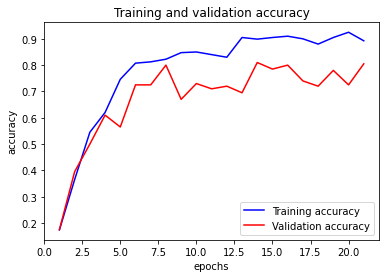

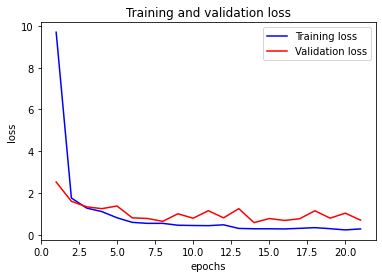

In [ ]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('Accuracy_resnet50.tiff')
plt.savefig('accuracyresnet.pdf',dpi=600,bbox_inches='tight')
plt.savefig('accuracyresnet.svg',dpi=600,bbox_inches='tight')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('Loss_resnet50.tiff')
plt.savefig('lossresnet.pdf',dpi=600,bbox_inches='tight')
plt.savefig('lossresnet.svg',dpi=600,bbox_inches='tight')

In [ ]:
import tensorflow as tf

from keras.models import load_model

model_resnet50.save('Model_resnet50')

INFO:tensorflow:Assets written to: Model_resnet50\assets


INFO:tensorflow:Assets written to: Model_resnet50\assets
C:\Users\juhai\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\juhai\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
model = models.load_model("Model_resnet50")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(8, 8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=14)

    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    plt.tight_layout()

In [ ]:
Y_pred_resnet= model_resnet50.predict_generator(test_generator)
y_pred_resnet = np.argmax(Y_pred_resnet, axis=1)


<ipython-input-16-e848b987d37b>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_resnet= model_resnet50.predict_generator(test_generator)


Confusion matrix, without normalization
[[20  0  0  0  0  0  0  0]
 [ 2 16  2  0  0  0  0  0]
 [ 2  0 17  0  0  1  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 8  0  1  1  0  8  0  2]
 [ 0  1  1  1  0  0 17  0]
 [ 0  1  1  0  0  0  0 18]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.1  0.8  0.1  0.   0.   0.   0.   0.  ]
 [0.1  0.   0.85 0.   0.   0.05 0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.4  0.   0.05 0.05 0.   0.4  0.   0.1 ]
 [0.   0.05 0.05 0.05 0.   0.   0.85 0.  ]
 [0.   0.05 0.05 0.   0.   0.   0.   0.9 ]]


<Figure size 432x288 with 0 Axes>

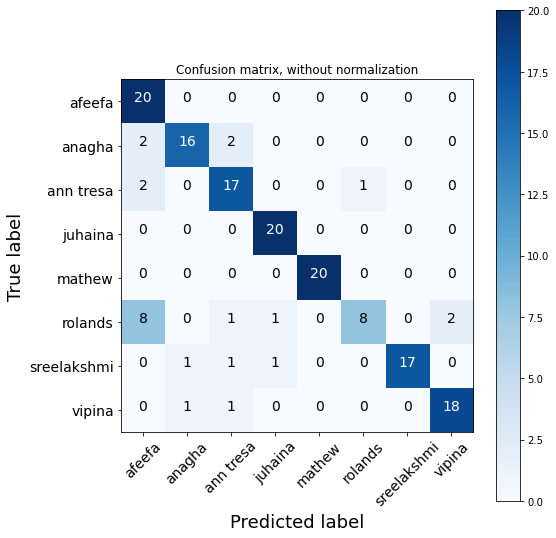

<Figure size 432x288 with 0 Axes>

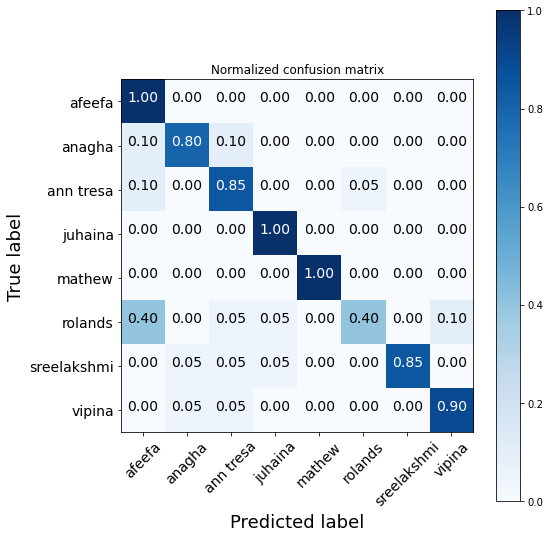

In [ ]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred_resnet)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=category_names,
                      title='Confusion matrix, without normalization')
plt.savefig('cnfwn_resnet50.tiff')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=category_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('cnfn_resnet50.tiff')
plt.savefig('cnfnresnet.pdf',dpi=600,bbox_inches='tight')
plt.savefig('cnfnresnet.svg',dpi=600,bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names= ['afeefa','anagha','ann tresa','juhaina','mathew','rolands','sreelakshmi','vipina']

print(classification_report(test_generator.classes, y_pred_resnet ,target_names=target_names))

              precision    recall  f1-score   support

      afeefa       0.62      1.00      0.77        20
      anagha       0.89      0.80      0.84        20
   ann tresa       0.77      0.85      0.81        20
     juhaina       0.91      1.00      0.95        20
      mathew       1.00      1.00      1.00        20
     rolands       0.89      0.40      0.55        20
 sreelakshmi       1.00      0.85      0.92        20
      vipina       0.90      0.90      0.90        20

    accuracy                           0.85       160
   macro avg       0.87      0.85      0.84       160
weighted avg       0.87      0.85      0.84       160



In [ ]:
for c in range(8):
    tp = cnf_matrix[c,c]
    fp = sum(cnf_matrix[:,c]) -cnf_matrix[c,c]
    fn = sum(cnf_matrix[c,:]) - cnf_matrix[c,c]
    tn = sum(np.delete(sum(cnf_matrix)-cnf_matrix[c,:],c))

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    f1_score = 2*((precision*recall)/(precision+recall))


    #print(f"for class {c}: acc {accuracy}, recall {recall},\
    #      precision {precision}, f1 {f1_score}")
    print("for class {}: recall {}, specificity {}\
          precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))

##    print("tp: ", tp)
##    print("fp: ", fp)
##    print("fn: ", fn)
##    print("tn: ", tn)

for class 0: recall 1.0, specificity 0.9143          precision 0.625, f1 0.7692
for class 1: recall 0.8, specificity 0.9857          precision 0.8889, f1 0.8421
for class 2: recall 0.85, specificity 0.9643          precision 0.7727, f1 0.8095
for class 3: recall 1.0, specificity 0.9857          precision 0.9091, f1 0.9524
for class 4: recall 1.0, specificity 1.0          precision 1.0, f1 1.0
for class 5: recall 0.4, specificity 0.9929          precision 0.8889, f1 0.5517
for class 6: recall 0.85, specificity 1.0          precision 1.0, f1 0.9189
for class 7: recall 0.9, specificity 0.9857          precision 0.9, f1 0.9


In [ ]:
test_subset_data_dir = "dataset/test_sub"

test_subset_generator = test_datagen.flow_from_directory(
test_subset_data_dir,
batch_size = 32,
target_size = (img_height, img_width),
class_mode = "categorical",
shuffle=False)

Found 8 images belonging to 8 classes.


<ipython-input-54-f03f1e385cf6>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_resnet = model_resnet50.predict_generator(test_subset_generator)


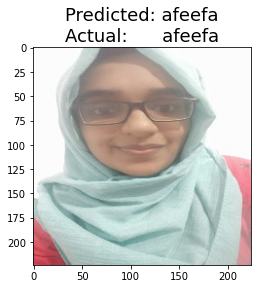

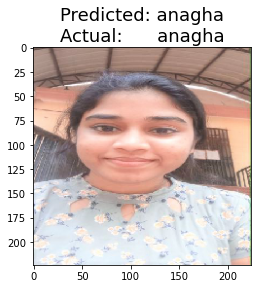

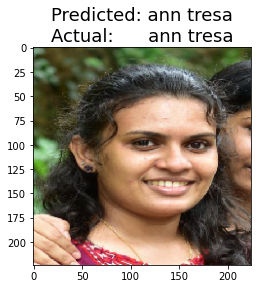

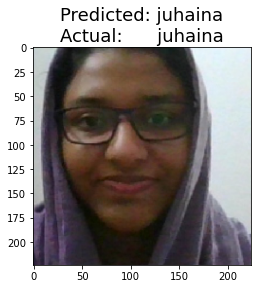

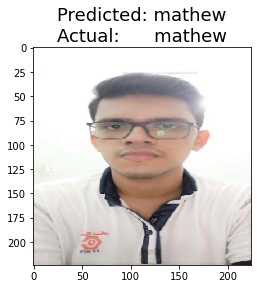

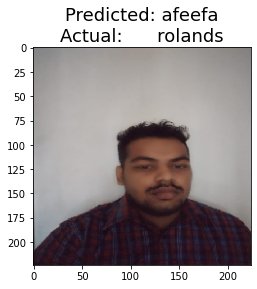

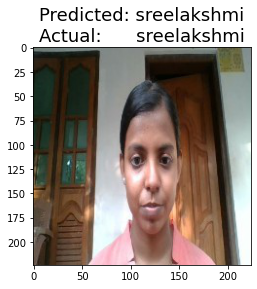

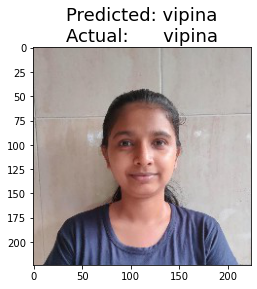

In [ ]:
Y_pred_resnet = model_resnet50.predict_generator(test_subset_generator)
y_pred_resnet = np.argmax(Y_pred_resnet, axis=1)
img_nr = 0
for subdir, dirs, files in os.walk('dataset/test_sub'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file,target_size=(img_height,img_width))
        pred_emotion = category_names[y_pred_resnet[img_nr]]
        real_emotion = category_names[test_subset_generator.classes[img_nr]]
        plt.figure()
        plt.title('Predicted: ' + pred_emotion + '\n' + 'Actual:      ' + real_emotion,fontsize=18)
        img_nr = img_nr +1
        plt.imshow(image)
        plt.savefig('resnet/'+ str(img_nr) + '.tiff',dpi=600,bbox_inches='tight')
        plt.savefig('resnet/'+ str(img_nr) + '.pdf',dpi=600,bbox_inches='tight')
        plt.savefig('resnet/'+ str(img_nr) + '.svg',dpi=600,bbox_inches='tight')

# VGG16

In [ ]:
img_height, img_width = 224,224
vgg16_base= vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

In [ ]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in vgg16_base.layers:
    layer.trainable=False
for layer in vgg16_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001F627F2DBB0> False
<keras.layers.convolutional.Conv2D object at 0x000001F62A025A30> False
<keras.layers.convolutional.Conv2D object at 0x000001F62816BA90> False
<keras.layers.pooling.MaxPooling2D object at 0x000001F620AA0310> False
<keras.layers.convolutional.Conv2D object at 0x000001F6296AB880> False
<keras.layers.convolutional.Conv2D object at 0x000001F6780B5D30> False
<keras.layers.pooling.MaxPooling2D object at 0x000001F6298880D0> False
<keras.layers.convolutional.Conv2D object at 0x000001F62AF4E430> False
<keras.layers.convolutional.Conv2D object at 0x000001F62B0AEE20> False
<keras.layers.convolutional.Conv2D object at 0x000001F62E692460> False
<keras.layers.pooling.MaxPooling2D object at 0x000001F62B0AE9A0> False
<keras.layers.convolutional.Conv2D object at 0x000001F62B0B28B0> False
<keras.layers.convolutional.Conv2D object at 0x000001F62B0AEEB0> False
<keras.layers.convolutional.Conv2D object at 0x000001F62D1DA4C0> False
<ker

In [ ]:
model_vgg16=Sequential()
model_vgg16.add(vgg16_base)
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dense(nb_categories, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 module_wrapper_3 (ModuleWra  (None, 512)              262656    
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 512)              262656    
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 8)                4104      
 pper)                                                           
                                                                 
Total params: 15,244,104
Trainable params: 529,416
Non-trainable params: 14,714,688
____________________________________

In [ ]:
learning_rate = 5e-5
epochs =50
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
model_vgg16.compile(loss="categorical_crossentropy",
   optimizer='adam',
   metrics = ['accuracy'])

In [ ]:
history_vgg16 = model_vgg16.fit(train_generator,
                              epochs=50,
                              shuffle=True,
                              validation_data=val_generator,
                              callbacks=[early]
                              )

Epoch 1/50
25/25 [==============================] - 94s 4s/step - loss: 1.0154 - accuracy: 0.7188 - val_loss: 0.2882 - val_accuracy: 0.9550
Epoch 2/50
25/25 [==============================] - 94s 4s/step - loss: 0.0745 - accuracy: 0.9900 - val_loss: 0.1338 - val_accuracy: 0.9700
Epoch 3/50
25/25 [==============================] - 97s 4s/step - loss: 0.0303 - accuracy: 0.9962 - val_loss: 0.1441 - val_accuracy: 0.9650
Epoch 4/50
25/25 [==============================] - 97s 4s/step - loss: 0.0237 - accuracy: 0.9975 - val_loss: 0.1648 - val_accuracy: 0.9550
Epoch 5/50
25/25 [==============================] - 96s 4s/step - loss: 0.0128 - accuracy: 0.9975 - val_loss: 0.1652 - val_accuracy: 0.9650
Epoch 6/50
25/25 [==============================] - 97s 4s/step - loss: 0.0083 - accuracy: 0.9987 - val_loss: 0.1590 - val_accuracy: 0.9750
Epoch 7/50
25/25 [==============================] - 95s 4s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1231 - val_accuracy: 0.9750
Epoch 8/50
25/25 [==

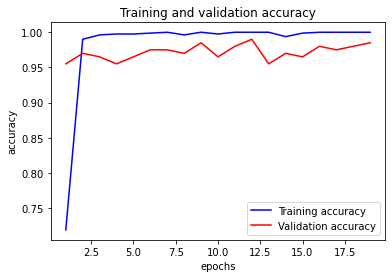

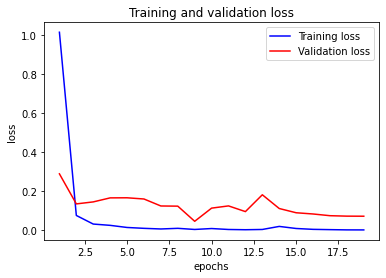

In [ ]:
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('Accuracy_vgg16_3.tiff')
plt.savefig('accuracyvgg.pdf',dpi=600,bbox_inches='tight')
plt.savefig('accuracyvgg.svg',dpi=600,bbox_inches='tight')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('Loss_vgg16_3.tiff')
plt.savefig('lossvgg.pdf',dpi=600,bbox_inches='tight')
plt.savefig('lossvgg.svg',dpi=600,bbox_inches='tight')

In [ ]:
Y_pred_vgg16 = model_vgg16.predict_generator(test_generator)
y_pred_vgg16 = np.argmax(Y_pred_vgg16, axis=1)

<ipython-input-30-3ca68a650074>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_vgg16 = model_vgg16.predict_generator(test_generator)


Confusion matrix, without normalization
[[20  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0]
 [ 0  0 19  0  1  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  5 15  0  0]
 [ 0  0  1  0  1  0 18  0]
 [ 0  0  0  0  2  0  0 18]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.95 0.   0.05 0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.25 0.75 0.   0.  ]
 [0.   0.   0.05 0.   0.05 0.   0.9  0.  ]
 [0.   0.   0.   0.   0.1  0.   0.   0.9 ]]


<Figure size 432x288 with 0 Axes>

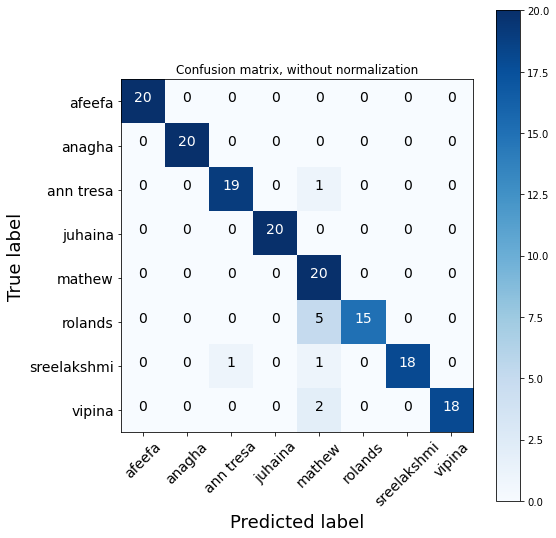

<Figure size 432x288 with 0 Axes>

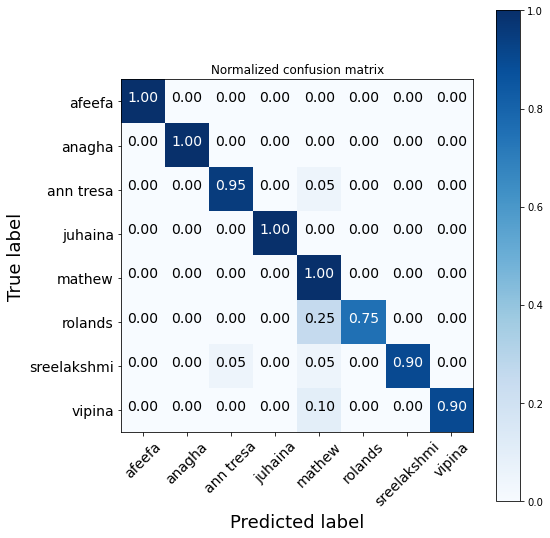

In [ ]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred_vgg16)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=category_names,
                      title='Confusion matrix, without normalization')
plt.savefig('cnfwn_vgg16.tiff')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=category_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('cnfn_vgg16.tiff')
plt.savefig('cnfnvgg.pdf',dpi=600,bbox_inches='tight')
plt.savefig('cnfnvgg.svg',dpi=600,bbox_inches='tight')
plt.show()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_generator.classes, y_pred_vgg16)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 93.8% 


In [ ]:
from sklearn.metrics import classification_report
target_names= ['afeefa','anagha','ann tresa','juhaina','mathew','rolands','sreelakshmi','vipina']

print(classification_report(test_generator.classes, y_pred_vgg16 ,target_names=target_names))

              precision    recall  f1-score   support

      afeefa       1.00      1.00      1.00        20
      anagha       1.00      1.00      1.00        20
   ann tresa       0.95      0.95      0.95        20
     juhaina       1.00      1.00      1.00        20
      mathew       0.69      1.00      0.82        20
     rolands       1.00      0.75      0.86        20
 sreelakshmi       1.00      0.90      0.95        20
      vipina       1.00      0.90      0.95        20

    accuracy                           0.94       160
   macro avg       0.95      0.94      0.94       160
weighted avg       0.95      0.94      0.94       160



In [ ]:
cf_matrix_vgg=confusion_matrix(test_generator.classes, y_pred_vgg16)
print('confusion matrix\n',cf_matrix_vgg)

confusion matrix
 [[20  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0]
 [ 0  0 19  0  1  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  5 15  0  0]
 [ 0  0  1  0  1  0 18  0]
 [ 0  0  0  0  2  0  0 18]]


In [ ]:
for c in range(8):
    tp = cf_matrix_vgg[c,c]
    fp = sum(cf_matrix_vgg[:,c]) -cf_matrix_vgg[c,c]
    fn = sum(cf_matrix_vgg[c,:]) - cf_matrix_vgg[c,c]
    tn = sum(np.delete(sum(cf_matrix_vgg)-cf_matrix_vgg[c,:],c))

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    f1_score = 2*((precision*recall)/(precision+recall))


    #print(f"for class {c}: acc {accuracy}, recall {recall},\
    #      precision {precision}, f1 {f1_score}")
    print("for class {}: recall {}, specificity {}\
          precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))

##    print("tp: ", tp)
##    print("fp: ", fp)
##    print("fn: ", fn)
##    print("tn: ", tn)

for class 0: recall 1.0, specificity 1.0          precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0          precision 1.0, f1 1.0
for class 2: recall 0.95, specificity 0.9929          precision 0.95, f1 0.95
for class 3: recall 1.0, specificity 1.0          precision 1.0, f1 1.0
for class 4: recall 1.0, specificity 0.9357          precision 0.6897, f1 0.8163
for class 5: recall 0.75, specificity 1.0          precision 1.0, f1 0.8571
for class 6: recall 0.9, specificity 1.0          precision 1.0, f1 0.9474
for class 7: recall 0.9, specificity 1.0          precision 1.0, f1 0.9474


<ipython-input-36-49d32e9f8410>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_vgg16 = model_vgg16.predict_generator(test_subset_generator)


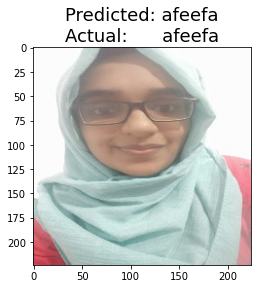

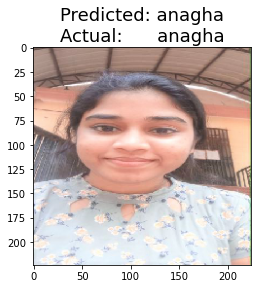

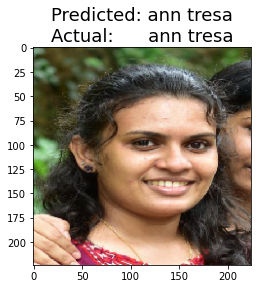

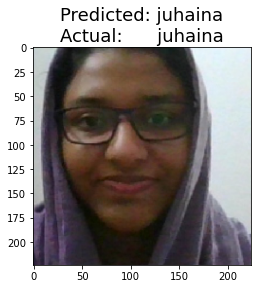

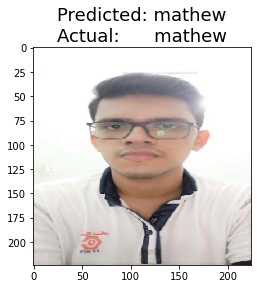

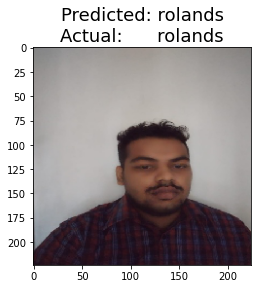

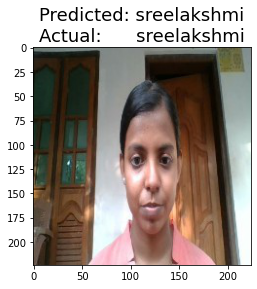

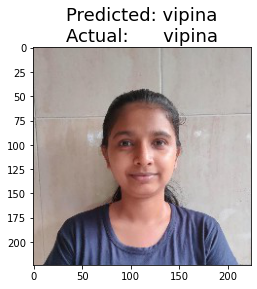

In [ ]:
from  matplotlib.backends.backend_pdf import PdfPages
Y_pred_vgg16 = model_vgg16.predict_generator(test_subset_generator)
y_pred_vgg16 = np.argmax(Y_pred_vgg16, axis=1)

img_nr = 0
for subdir, dirs, files in os.walk('dataset/test_sub'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file,target_size=(img_height,img_width))
        pred_emotion = category_names[y_pred_vgg16[img_nr]]
        real_emotion = category_names[test_subset_generator.classes[img_nr]]
        plt.figure()
        plt.title('Predicted: ' + pred_emotion + '\n' + 'Actual:      ' + real_emotion,fontsize=18)
        img_nr = img_nr +1
        plt.imshow(image)
        plt.savefig('vgg/'+ str(img_nr) + '.tiff')
        plt.savefig('vgg/'+ str(img_nr) + '.pdf',dpi=600,bbox_inches='tight')
        plt.savefig('vgg/'+ str(img_nr) + '.svg',dpi=600,bbox_inches='tight')


# DENSENET

In [ ]:
img_height, img_width = 224,224
densenet_base = DenseNet169(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

In [ ]:
densenet_base.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
for layer in densenet_base.layers:
    layer.trainable=False
for layer in densenet_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001F66CB4ACA0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001F6290E9B20> False
<keras.layers.convolutional.Conv2D object at 0x000001F629100190> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F66CB4AF70> False
<keras.layers.core.activation.Activation object at 0x000001F627EA6B80> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001F66EE5F7C0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001F62F808D30> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F62F606A30> False
<keras.layers.core.activation.Activation object at 0x000001F6290E9580> False
<keras.layers.convolutional.Conv2D object at 0x000001F66ECE4040> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F62F425DC0> False
<keras.layers.core.activation.Activation object at 0x000001F62F7F20D0> False
<keras.layers.conv

In [ ]:
model_densenet=Sequential()
model_densenet.add(densenet_base)
model_densenet.add(layers.Dense(512, activation='relu'))
model_densenet.add(layers.Dense(512, activation='relu'))
model_densenet.add(layers.Dense(nb_categories, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
model_densenet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 module_wrapper_6 (ModuleWra  (None, 512)              852480    
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 512)              262656    
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 8)                4104      
 pper)                                                           
                                                                 
Total params: 13,762,120
Trainable params: 1,119,240
Non-trainable params: 12,642,880
__________________________________

In [ ]:
learning_rate = 5e-5
epochs =50
early = EarlyStopping(monitor='val_loss', patience=9, verbose=1, mode='auto')
model_densenet.compile(loss="categorical_crossentropy",
   optimizer='adam',
   metrics = ['accuracy'])

In [ ]:
history_densenet = model_densenet.fit(train_generator,
                              epochs=50,
                              shuffle=True,
                              validation_data=val_generator,
                              callbacks=[early]
                              )

Epoch 1/50
25/25 [==============================] - 63s 2s/step - loss: 1.0404 - accuracy: 0.7588 - val_loss: 0.2408 - val_accuracy: 0.9500
Epoch 2/50
25/25 [==============================] - 56s 2s/step - loss: 0.0736 - accuracy: 0.9812 - val_loss: 0.0886 - val_accuracy: 0.9800
Epoch 3/50
25/25 [==============================] - 56s 2s/step - loss: 0.0269 - accuracy: 0.9900 - val_loss: 0.3522 - val_accuracy: 0.9200
Epoch 4/50
25/25 [==============================] - 56s 2s/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.1560 - val_accuracy: 0.9650
Epoch 5/50
25/25 [==============================] - 56s 2s/step - loss: 0.0250 - accuracy: 0.9912 - val_loss: 0.0329 - val_accuracy: 0.9850
Epoch 6/50
25/25 [==============================] - 56s 2s/step - loss: 0.0466 - accuracy: 0.9825 - val_loss: 0.0359 - val_accuracy: 0.9850
Epoch 7/50
25/25 [==============================] - 199s 8s/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.1817 - val_accuracy: 0.9450
Epoch 8/50
25/25 [=

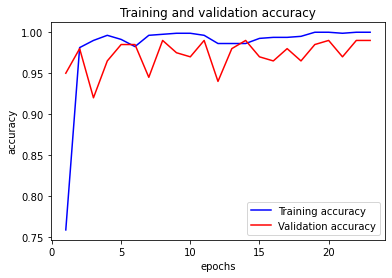

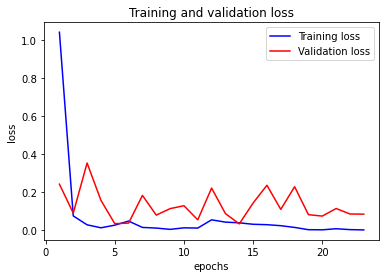

In [ ]:
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('Accuracy_densenet.tiff')
plt.savefig('Accuracy_densenet.pdf',dpi=600,bbox_inches='tight')
plt.savefig('Accuracy_densenet.svg',dpi=600,bbox_inches='tight')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('Loss_densenet.tiff')
plt.savefig('loss_densenet.pdf',dpi=600,bbox_inches='tight')
plt.savefig('loss_densenet.svg',dpi=600,bbox_inches='tight')

In [ ]:
Y_pred_densenet = model_densenet.predict_generator(test_generator)
y_pred_densenet = np.argmax(Y_pred_densenet, axis=1)

<ipython-input-44-d42acb383ed1>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_densenet = model_densenet.predict_generator(test_generator)


Confusion matrix, without normalization
[[20  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  2 18  0  0]
 [ 0  0  1  1  0  0 18  0]
 [ 0  0  0  0  1  0  0 19]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.1  0.9  0.   0.  ]
 [0.   0.   0.05 0.05 0.   0.   0.9  0.  ]
 [0.   0.   0.   0.   0.05 0.   0.   0.95]]


<Figure size 432x288 with 0 Axes>

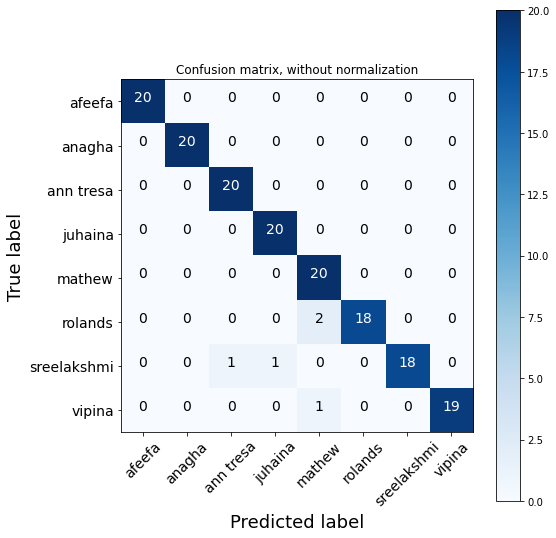

<Figure size 432x288 with 0 Axes>

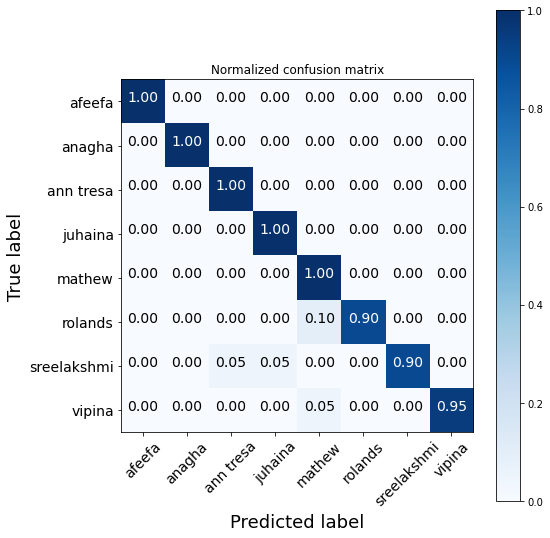

In [ ]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred_densenet)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=category_names,
                      title='Confusion matrix, without normalization')
plt.savefig('cnfwn_densenet.tiff')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=category_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('cnfn_densenet.tiff')
plt.savefig('cnfn_densenet.pdf',dpi=600,bbox_inches='tight')
plt.savefig('cnfn_densenet.svg',dpi=600,bbox_inches='tight')
plt.show()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_generator.classes, y_pred_densenet)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 96.9% 


In [ ]:
cf_matrix_densenet=confusion_matrix(test_generator.classes, y_pred_densenet)
print('confusion matrix\n',cf_matrix_densenet)

confusion matrix
 [[20  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  2 18  0  0]
 [ 0  0  1  1  0  0 18  0]
 [ 0  0  0  0  1  0  0 19]]


In [ ]:
from sklearn.metrics import classification_report
target_names= ['afeefa','anagha','ann tresa','juhaina','mathew','rolands','sreelakshmi','vipina']

print(classification_report(test_generator.classes, y_pred_densenet ,target_names=target_names))

              precision    recall  f1-score   support

      afeefa       1.00      1.00      1.00        20
      anagha       1.00      1.00      1.00        20
   ann tresa       0.95      1.00      0.98        20
     juhaina       0.95      1.00      0.98        20
      mathew       0.87      1.00      0.93        20
     rolands       1.00      0.90      0.95        20
 sreelakshmi       1.00      0.90      0.95        20
      vipina       1.00      0.95      0.97        20

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



In [ ]:
for c in range(8):
    tp = cf_matrix_densenet[c,c]
    fp = sum(cf_matrix_densenet[:,c]) -cf_matrix_densenet[c,c]
    fn = sum(cf_matrix_densenet[c,:]) - cf_matrix_densenet[c,c]
    tn = sum(np.delete(sum(cf_matrix_densenet)-cf_matrix_densenet[c,:],c))

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    f1_score = 2*((precision*recall)/(precision+recall))


    #print(f"for class {c}: acc {accuracy}, recall {recall},\
    #      precision {precision}, f1 {f1_score}")
    print("for class {}: recall {}, specificity {}\
          precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))

##    print("tp: ", tp)
##    print("fp: ", fp)
##    print("fn: ", fn)
##    print("tn: ", tn)

for class 0: recall 1.0, specificity 1.0          precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0          precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 0.9929          precision 0.9524, f1 0.9756
for class 3: recall 1.0, specificity 0.9929          precision 0.9524, f1 0.9756
for class 4: recall 1.0, specificity 0.9786          precision 0.8696, f1 0.9302
for class 5: recall 0.9, specificity 1.0          precision 1.0, f1 0.9474
for class 6: recall 0.9, specificity 1.0          precision 1.0, f1 0.9474
for class 7: recall 0.95, specificity 1.0          precision 1.0, f1 0.9744


<ipython-input-50-9f112f69cf77>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_densenet = model_densenet.predict_generator(test_subset_generator)


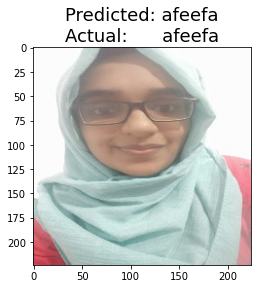

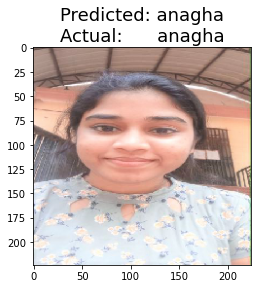

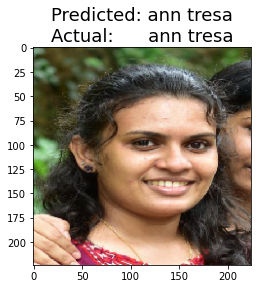

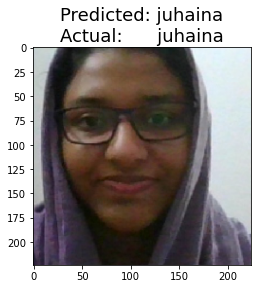

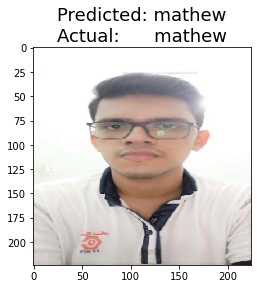

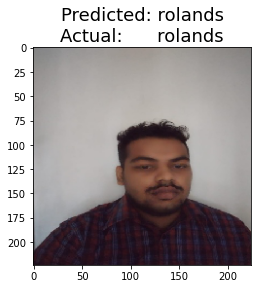

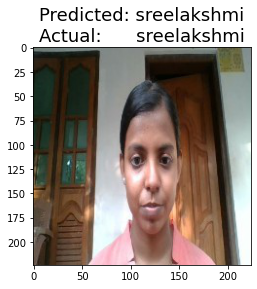

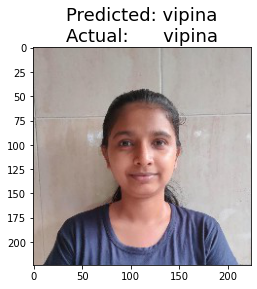

In [ ]:
Y_pred_densenet = model_densenet.predict_generator(test_subset_generator)
y_pred_densenet = np.argmax(Y_pred_densenet, axis=1)

img_nr = 0
for subdir, dirs, files in os.walk('dataset/test_sub'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file,target_size=(img_height,img_width))
        pred_emotion = category_names[y_pred_densenet[img_nr]]
        real_emotion = category_names[test_subset_generator.classes[img_nr]]
        plt.figure()
        plt.title('Predicted: ' + pred_emotion + '\n' + 'Actual:      ' + real_emotion ,fontsize=18)
        img_nr = img_nr +1
        plt.imshow(image)
        plt.savefig('densenet/'+ str(img_nr) + '.tiff')
        plt.savefig('densenet/'+ str(img_nr) + '.pdf',dpi=600,bbox_inches='tight')
        plt.savefig('densenet/'+ str(img_nr) + '.svg',dpi=600,bbox_inches='tight')


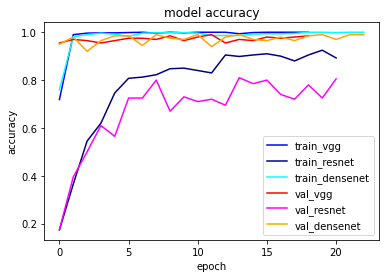

In [ ]:
plt.plot(history_vgg16.history['accuracy'],'blue',label='train_vgg')
plt.plot(history_resnet.history['accuracy'],'navy',label='train_resnet')
plt.plot(history_densenet.history['accuracy'],'cyan',label='train_densenet')
plt.plot(history_vgg16.history['val_accuracy'],'red',label='val_vgg')
plt.plot(history_resnet.history['val_accuracy'],'magenta',label='val_resnet')
plt.plot(history_densenet.history['val_accuracy'],'orange',label='val_densenet')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig('accuracy.tiff')
plt.savefig('accuracy.pdf',dpi=600,bbox_inches='tight')
plt.savefig('accuracy.svg',dpi=600,bbox_inches='tight')
plt.show()

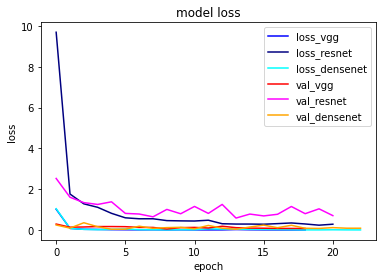

In [ ]:
plt.plot(history_vgg16.history['loss'],'blue',label='loss_vgg')
plt.plot(history_resnet.history['loss'],'navy',label='loss_resnet')
plt.plot(history_densenet.history['loss'],'cyan',label='loss_densenet')
plt.plot(history_vgg16.history['val_loss'],'red',label='val_vgg')
plt.plot(history_resnet.history['val_loss'],'magenta',label='val_resnet')
plt.plot(history_densenet.history['val_loss'],'orange',label='val_densenet')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss.tiff')
plt.savefig('loss.pdf',dpi=600,bbox_inches='tight')
plt.savefig('loss.svg',dpi=600,bbox_inches='tight')
plt.show()